### <center>Chestnut Bur Detection and Segmentation using MaskRCNN in PyTorch</center>

In [1]:
%matplotlib inline

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, Subset, DataLoader
from torchvision import transforms as _transforms, tv_tensors
import torchvision.transforms.v2 as T
from cv2 import fillPoly
import json
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from pathlib import Path
from matplotlib.patches import Polygon
import shutil

from fastai.vision.all import RandomSplitter ## FIXME: Change this to torch.utils.data.random_split or use indices 

##### Load the image and annotation data

In [2]:
# load annotations from json file here: "C:\Users\exx\Downloads\Route 9 Orchard 4.v1-test_dataset.coco-segmentation\train\_annotations.coco.json"
annos = json.load(open("C:/Users/exx/Downloads/Route 9 Orchard 4.v1-test_dataset.coco-segmentation/train/_annotations.coco.json"))

In [3]:
for key in annos.keys():
    print(annos[key])

{'year': '2024', 'version': '1', 'description': 'Exported from roboflow.com', 'contributor': '', 'url': 'https://public.roboflow.com/object-detection/undefined', 'date_created': '2024-08-13T19:46:53+00:00'}
[{'id': 1, 'url': 'https://creativecommons.org/licenses/by-nc-sa/4.0/', 'name': 'BY-NC-SA 4.0'}]
[{'id': 0, 'name': 'Chestnut-burr-CNsm', 'supercategory': 'none'}, {'id': 1, 'name': 'canopy', 'supercategory': 'Chestnut-burr-CNsm'}, {'id': 2, 'name': 'chestnut bur', 'supercategory': 'Chestnut-burr-CNsm'}]
[{'id': 0, 'license': 1, 'file_name': '107_png.rf.0890c9586fe43c53410d1f02f076ff4c.jpg', 'height': 1412, 'width': 1453, 'date_captured': '2024-08-13T19:46:53+00:00'}, {'id': 1, 'license': 1, 'file_name': '105_png.rf.4c53d3a84ad8e41bda83d406bd6327f8.jpg', 'height': 1366, 'width': 1319, 'date_captured': '2024-08-13T19:46:53+00:00'}, {'id': 2, 'license': 1, 'file_name': '101_png.rf.6ea0ba77d29d4b1cb1827ca8c3dcbb91.jpg', 'height': 1458, 'width': 1468, 'date_captured': '2024-08-13T19:46:

In [4]:
# convert the annos dict to a df, where each row is an image and the columns are the file name, the category name,
# the polygon coords, bbox, area, and iscrowd
import pandas as pd

annos_df = pd.DataFrame(annos["annotations"])
df = pd.DataFrame()
df["tree_id"] = annos_df["image_id"].apply(lambda x: annos["images"][x]["file_name"].split("_")[0])
df["file_name"] = annos_df["image_id"].apply(lambda x: annos["images"][x]["file_name"])
df["file_name"] = df["file_name"].apply(lambda x: x.split("_")[0] + ".png")
categories = [cat["name"] for cat in annos["categories"]]
df["category_name"] = annos_df["category_id"].apply(lambda x: categories[x])
df["bbox"] = annos_df["bbox"].apply(lambda x: torch.tensor(x))
df["area"] = annos_df["area"].apply(lambda x: torch.tensor(x))
df["segmentation"] = annos_df["segmentation"].apply(lambda x: torch.tensor(x))
df["iscrowd"] = annos_df["iscrowd"]

In [5]:
image_dir = "C:\\Users\\exx\\EasyIDP\\Route9_Orchard4\\Outputs\\Roboflow\\images"

image_names = df["file_name"].unique()

filtered_image_dir = "C:\\Users\\exx\\Deep Learning\\Chestnut_Bur_Instance_Segmentation\\filtered_images"
Path(filtered_image_dir).mkdir(exist_ok=True)
for image_name in image_names:
    shutil.copy(image_dir + "\\" + image_name, filtered_image_dir)

##### Plot Sample Image and Annotation Data

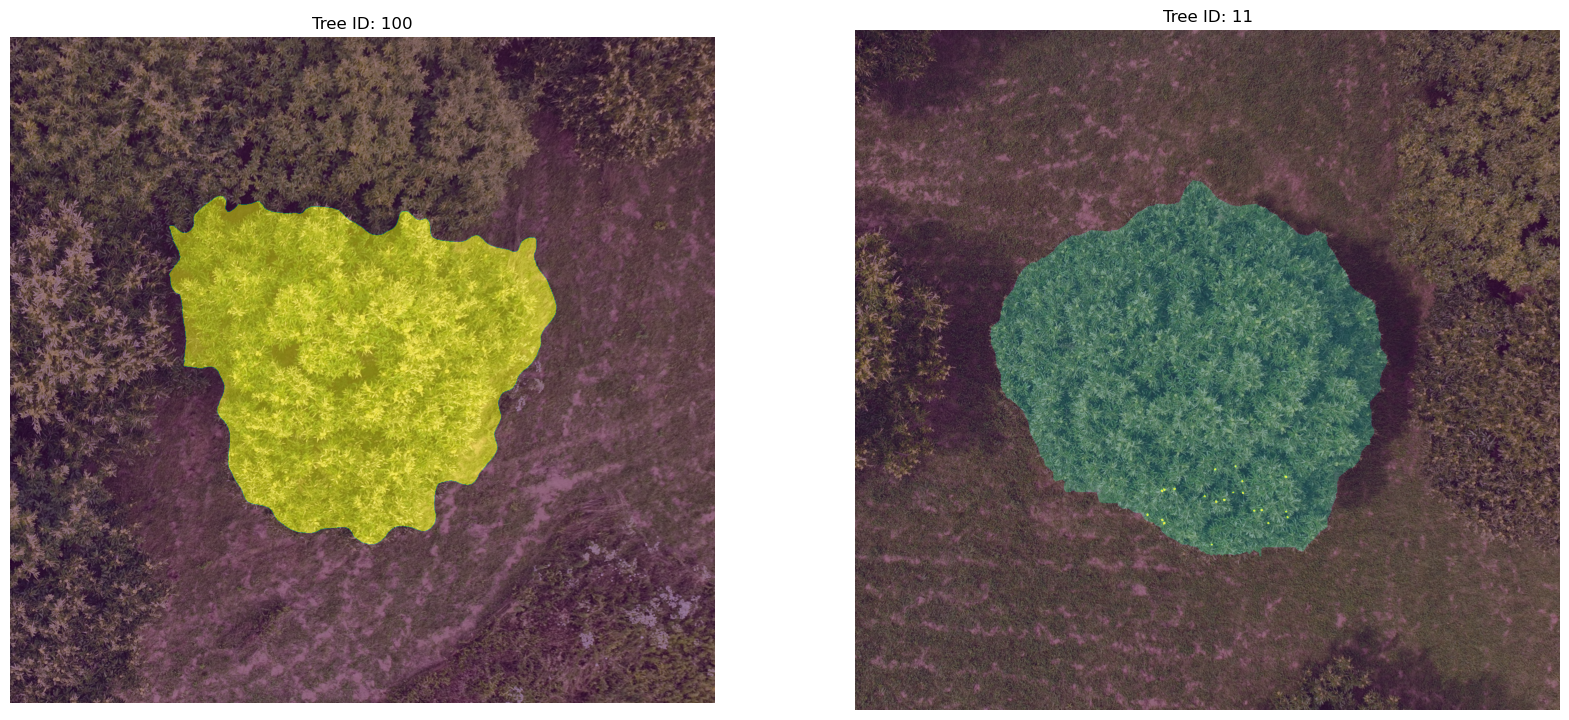

In [6]:
def mask_fill(mask, polys, color):
    for poly in polys:
        fillPoly(mask, [poly], color)
    return mask

def plot_images_with_masks(image_dir: Path, tree_id_list, df: pd.DataFrame):
    fig, axs = plt.subplots(1, len(tree_id_list), figsize=(20, 10))
    for i, tree_id in enumerate(tree_id_list):
        image_name = df[df["tree_id"] == tree_id]["file_name"].values[0]
        image = Image.open(Path(image_dir) / image_name)

        canopy_poly = df[(df["tree_id"] == tree_id) & (df["category_name"] == "canopy")]["segmentation"].values
        bur_poly = df[(df["tree_id"] == tree_id) & (df["category_name"] == "chestnut bur")]["segmentation"].values

        canopy_poly = [np.array(poly[0]).reshape(-1, 2).astype(np.int32) for poly in canopy_poly]
        bur_poly = [np.array(poly[0]).reshape(-1, 2).astype(np.int32) for poly in bur_poly]

        bur_masks = []
        for poly in bur_poly:
            bur_mask = np.zeros((image.height, image.width), dtype=np.uint8)
            bur_mask = mask_fill(bur_mask, [poly], 2)
            bur_masks.append(bur_mask)

        # Stack all masks together
        if bur_masks:
            background_mask = np.zeros((image.height, image.width, 1), dtype=np.uint8)
            canopy_mask = np.zeros((image.height, image.width, 1), dtype=np.uint8)
            canopy_mask = mask_fill(canopy_mask, canopy_poly, 1)
            bur_masks_stacked = np.stack(bur_masks, axis=-1)
            mask_image = np.concatenate([background_mask, canopy_mask, bur_masks_stacked], axis=-1)
        else:
            background_mask = np.zeros((image.height, image.width), dtype=np.uint8)
            canopy_mask = np.zeros((image.height, image.width), dtype=np.uint8)
            canopy_mask = mask_fill(canopy_mask, canopy_poly, 1)
            mask_image = np.stack((background_mask, canopy_mask), axis=-1)

        axs[i].imshow(image)
        axs[i].imshow(mask_image.sum(axis=-1), alpha=0.5)
        axs[i].axis("off")
        axs[i].set_title(f'Tree ID: {tree_id}')

    plt.show()

plot_images_with_masks(image_dir, ["100", "11"], df)

##### Pre-process and Transform Image and Annotation Data

##### Adapted from: https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html#an-instance-segmentation-model-for-pennfudan-dataset

In [7]:
# Custom dataset loader (PyTorch) for loading images and annotation data
class ChestnutBurSegmentation(Dataset):
    """Custom Dataset for Chestnut Bur Segmentation in UAV Images"""

    def __init__(self, image_dir, df, transform=None):
        self.image_dir = image_dir
        self.df = df
        self.transform = transform
        self.unique_tree_ids = self.df["tree_id"].unique()

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        tree_id = self.unique_tree_ids[idx]

        row = self.df[self.df["tree_id"] == tree_id].iloc[0]

        image_file = Path(self.image_dir) / row["file_name"]

        image = tv_tensors.Image(Image.open(image_file))

        height, width = image.shape[-2:]

        canopy_poly = df[(df["tree_id"] == tree_id) & (df["category_name"] == "canopy")]["segmentation"].values
        bur_poly = df[(df["tree_id"] == tree_id) & (df["category_name"] == "chestnut bur")]["segmentation"].values

        canopy_poly = [np.array(poly[0]).reshape(-1, 2).astype(np.int32) for poly in canopy_poly]
        bur_poly = [np.array(poly[0]).reshape(-1, 2).astype(np.int32) for poly in bur_poly]

        bur_masks = []
        for poly in bur_poly:
            bur_mask = np.zeros((height, width), dtype=np.uint8)
            bur_mask = mask_fill(bur_mask, [poly], 2)
            bur_masks.append(bur_mask)

        if bur_masks:
            background_mask = np.zeros((height, width, 1), dtype=np.uint8)
            canopy_mask = np.zeros((height, width, 1), dtype=np.uint8)
            canopy_mask = mask_fill(canopy_mask, canopy_poly, 1)
            bur_masks_stacked = np.stack(bur_masks, axis=-1)
            mask_image = np.concatenate([background_mask, canopy_mask, bur_masks_stacked], axis=-1).transpose(2, 0, 1)
        else:
            background_mask = np.zeros((height, width), dtype=np.uint8)
            canopy_mask = np.zeros((height, width), dtype=np.uint8)
            canopy_mask = mask_fill(canopy_mask, canopy_poly, 1)
            mask_image = np.stack((background_mask, canopy_mask), axis=-1).transpose(2, 0, 1)

        labels = self.df[self.df["tree_id"] == tree_id]["category_name"].values

        # encode categorical labels as integers
        labels = [categories.index(label) for label in labels]

        bboxes = self.df[self.df["tree_id"] == tree_id]["bbox"].values
        bboxes = [torch.tensor([bbox[0], bbox[1], bbox[0] + bbox[2], bbox[1] + bbox[3]], dtype = torch.float32) for bbox in bboxes] # convert to xyxy format
        bboxes = torch.stack([bbox for bbox in bboxes], dim=0) # (n_objects, 4)

        area = self.df[self.df["tree_id"] == tree_id]["area"].values

        iscrowd = self.df[self.df["tree_id"] == tree_id]["iscrowd"].values
        
        target = {}
        target["boxes"] = tv_tensors.BoundingBoxes(bboxes, format=tv_tensors.BoundingBoxFormat.XYXY, canvas_size=(height, width)) 
        target["labels"] = torch.as_tensor(labels, dtype = torch.int64) # (n_objects)
        target["image_id"] = int(tree_id)
        target["area"] = torch.stack([a.clone().detach().float() for a in area], dim=0) # (n_objects)
        target["iscrowd"] = torch.stack([torch.tensor(ic, dtype = torch.int64) for ic in iscrowd], dim=0) # (n_objects)

        if self.transform is not None:
            # normalize image using imagenet stats
            image = T.Compose([T.ToDtype(torch.float32, scale=True), T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])(image)
            image_and_mask = torch.cat((image, torch.tensor(mask_image, dtype=torch.float32)), dim=0)
            image_and_mask, target = self.transform(image_and_mask, target)
            image = image_and_mask[:image.shape[0], :, :] # slice out the transformed image
            mask_image = image_and_mask[image.shape[0]:, :].clone().detach().to(torch.uint8) # slice out the transformed mask
            target["masks"] = mask_image
        else:
            image = image
            target["masks"] = torch.from_numpy(mask_image)

        return image, target

    def collate_fn(batch):
        return tuple(zip(*batch))

    def __len__(self):
        return len(self.unique_tree_ids)

In [15]:
# define transforms for the dataset
def get_transform(train):
    transforms = []
    if train:
        transforms.append(T.RandomZoomOut(fill = {tv_tensors.Image: (255, 20, 147), tv_tensors.Mask: (0,0,0)},
                                          p = 0.5,
                                          side_range = (1.0, 1.4)))
        # transforms.append(T.RandomIoUCrop())
        transforms.append(T.Resize((448, 448), interpolation=T.InterpolationMode.NEAREST, antialias = True)) # no maintain aspect ratio
        transforms.append(T.RandomHorizontalFlip(0.5))
    else:
        transforms.append(T.Resize((448, 448), interpolation=T.InterpolationMode.NEAREST, antialias = True)) # no maintain aspect ratio
    transforms.append(T.ClampBoundingBoxes())
    transforms.append(T.SanitizeBoundingBoxes())
    return T.Compose(transforms)

In [16]:
sample_ds = ChestnutBurSegmentation(filtered_image_dir, df, get_transform(train = True))
sample_dl = DataLoader(sample_ds, batch_size = 24, shuffle = True, collate_fn = ChestnutBurSegmentation.collate_fn)

In [17]:
images, targets = next(iter(sample_dl))
images = [img for img in images]
targets = [{k: v for k, v in target.items()} for target in targets]

##### Plot transformed images, targets, masks to confirm data loads correctly

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


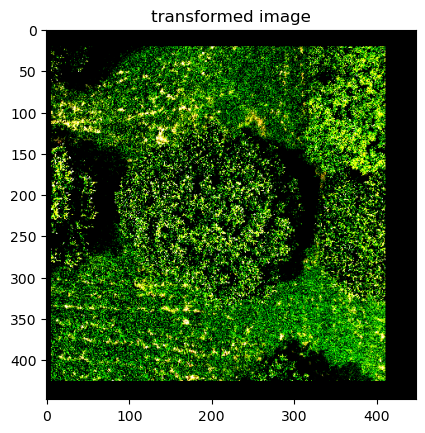

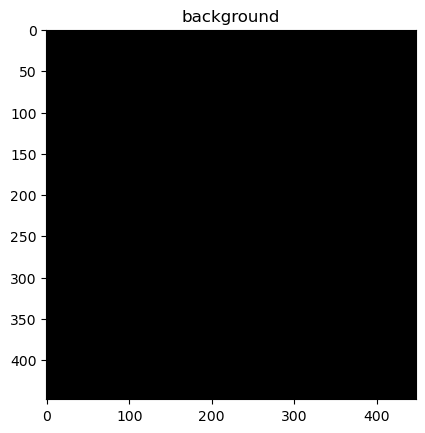

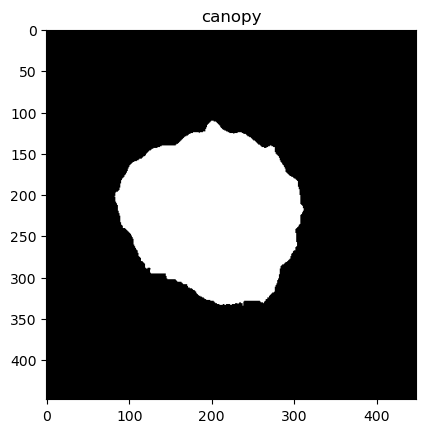

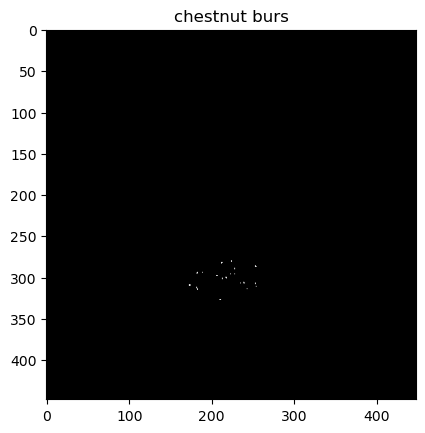

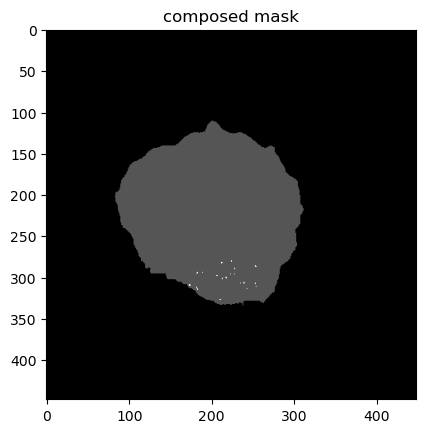

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


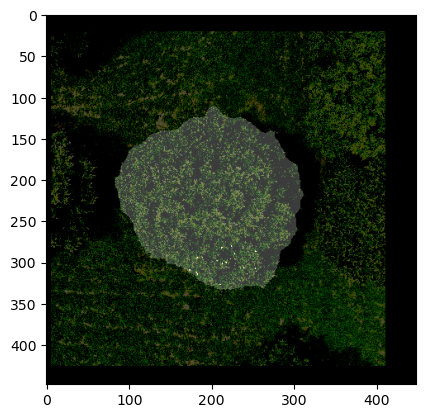

In [19]:
tree_ids = [target["image_id"] for target in targets]

image = images[tree_ids.index(11)].permute(1, 2, 0) if 11 in tree_ids else images[0].permute(1, 2, 0)
mask = targets[tree_ids.index(11)]["masks"].permute(1, 2, 0) if 11 in tree_ids else targets[0]["masks"].permute(1, 2, 0)


background_mask = mask[:, :, 0]
canopy_mask = mask[:, :, 1]
bur_mask = mask[:, :, 2:]

plt.imshow(image)
plt.title("transformed image")
plt.show()

plt.imshow(background_mask, cmap="gray")
plt.title("background")
plt.show()

plt.imshow(canopy_mask, cmap="gray")
plt.title("canopy")
plt.show()

plt.imshow(bur_mask.sum(axis=2), cmap="gray")
plt.title("chestnut burs")
plt.show()

plt.imshow(mask.sum(axis=2), cmap="gray")
plt.title("composed mask")
plt.show()

# plot mask on image
plt.imshow(image)
plt.imshow(mask.sum(axis=2), cmap='gray', alpha=0.7)

##### Construct MaskRCNN Model

In [12]:
import torchvision

def get_instance_segmentation_model(num_classes):
    # Load a Mask R-CNN instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn_v2(
        weights=torchvision.models.detection.MaskRCNN_ResNet50_FPN_V2_Weights.DEFAULT,
        weights_backbone=torchvision.models.ResNet50_Weights.DEFAULT
    )

    # Get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features

    # Replace the pre-trained head with a new one (note: +1 because of the background class)
    model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)

    # Get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256

    # Replace the mask predictor with a new one
    model.roi_heads.mask_predictor = torchvision.models.detection.mask_rcnn.MaskRCNNPredictor(
        in_features_mask,
        hidden_layer,
        num_classes
    )

    return model

In [13]:
print(get_instance_segmentation_model(3))

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
         

In [14]:
from detection_pytorch import engine

# train on the GPU or on the CPU, if a GPU is not available
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

num_classes = 3 # (background = 0, canopy = 1, chestnut bur = 2)

splits = RandomSplitter()(df["tree_id"].unique())

# use our dataset and defined transformations
train_ds = ChestnutBurSegmentation(filtered_image_dir, df, get_transform(train = True))
valid_ds = ChestnutBurSegmentation(filtered_image_dir, df, get_transform(train = False))

train_ds = Subset(train_ds, splits[0])
valid_ds = Subset(valid_ds, splits[1])

train_dl = DataLoader(train_ds, batch_size = 8, shuffle = True, collate_fn = ChestnutBurSegmentation.collate_fn)
valid_dl = DataLoader(valid_ds, batch_size = 1, shuffle = False, collate_fn = ChestnutBurSegmentation.collate_fn)

# get the model using our helper function
model = get_instance_segmentation_model(num_classes)

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(
    params,
    lr=0.005,
    momentum=0.9,
    weight_decay=0.0005
)

# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=3,
    gamma=0.1
)

num_epochs = 2

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    engine.train_one_epoch(model, optimizer, train_dl, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    engine.evaluate(model, valid_dl, device=device)

print("That's it!")

Epoch: [0]  [0/3]  eta: 0:00:05  lr: 0.002503  loss: 2.5968 (2.5968)  loss_classifier: 0.9237 (0.9237)  loss_box_reg: 0.1180 (0.1180)  loss_mask: 1.4847 (1.4847)  loss_objectness: 0.0549 (0.0549)  loss_rpn_box_reg: 0.0157 (0.0157)  time: 1.7426  data: 0.8049  max mem: 10004
Epoch: [0]  [2/3]  eta: 0:00:01  lr: 0.005000  loss: 2.6022 (2.8051)  loss_classifier: 0.9128 (0.8288)  loss_box_reg: 0.1180 (0.1187)  loss_mask: 1.4847 (1.3333)  loss_objectness: 0.0549 (0.3101)  loss_rpn_box_reg: 0.0213 (0.2142)  time: 1.3799  data: 0.8733  max mem: 10180
Epoch: [0] Total time: 0:00:04 (1.3806 s / it)
creating index...
index created!
Test:  [0/4]  eta: 0:00:02  model_time: 0.2975 (0.2975)  evaluator_time: 0.0559 (0.0559)  time: 0.6734  data: 0.3199  max mem: 10180
Test:  [3/4]  eta: 0:00:00  model_time: 0.2191 (0.2243)  evaluator_time: 0.0436 (0.0464)  time: 0.5193  data: 0.2449  max mem: 10180
Test: Total time: 0:00:02 (0.5207 s / it)
Averaged stats: model_time: 0.2191 (0.2243)  evaluator_time: 0